In [1]:
## Module imports
import pandas as pd
import sys
sys.path.append("..")
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.causalpfn import ATEEstimator
from functools import reduce

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## MAIN HYPERPARAMETER
N_DISC_VALUES = [2, 3]

## Main body
# Discretization function
def discretize_treatment(T: np.ndarray, N: int) -> np.ndarray:
    """Returns discretized version of T. Assumes range of T is [0, 1].

    Args:
        T (np.ndarray): The raw treatment data 
        N (int): The number of discretized treatment values to use

    Returns:
        np.ndarray: The discretized treatment data
    """
    dt = 1 / (N - 1)
    T_discrete = np.round(np.array(T, dtype=np.float32) / dt) * dt

    return T_discrete

# RMSE function
def calculate_rmse(y_pred, y_true):
    result = np.mean(np.power(y_pred - y_true, 2))
    result = np.sqrt(result)

    return result

In [3]:
def sigmoid(t): return 1. / (1. + np.exp(-1. * t))

In [4]:
## DGP from https://github.com/CausalTeam/ADMIT/blob/main
n, d = 2000, 6

# Generate random covariates X1, ..., X6 in [-1, 1]
X = np.random.uniform(-1, 1, (n, d))
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
x4 = X[:, 3]
x5 = X[:, 4]
x6 = X[:, 5]

# Generate treatment 
mu_1 =  (10. * np.sin(np.maximum(x1, np.maximum(x2, x3))) + np.maximum(x3, np.maximum(x4, x5))**3)/(1. + (x1 + x5)**2) + np.sin(0.5 * x3) * (1. + np.exp(x4 - 0.5 * x3)) + x3**2 + 2. * np.sin(x4) + 2.*x5 - 6.5
T = np.random.normal(mu_1, 0.5)
T = sigmoid(T)

# Generate outcomes
mu_2 = np.cos(2 * np.pi * (T - 0.5)) * (T ** 2 + (4 * np.maximum(x1, x6) ** 3) * np.sin(x4) / (1 + 2 * x3 ** 2))
Y = np.random.normal(mu_2, 0.5)

In [5]:
# Generated expected potential outcomes empirically
treatment_doses = np.linspace(0, 1, 100)
effects = []
for t in treatment_doses:
    T_intervention = t * np.ones(T.shape)
    mu_2_intervention = np.cos(2 * np.pi * (T_intervention - 0.5)) * (T_intervention ** 2 + (4 * np.maximum(x1, x6) ** 3) * np.sin(x4) / (1 + 2 * x3 ** 2))
    effects.append(mu_2_intervention.mean())
effects = np.array(effects)

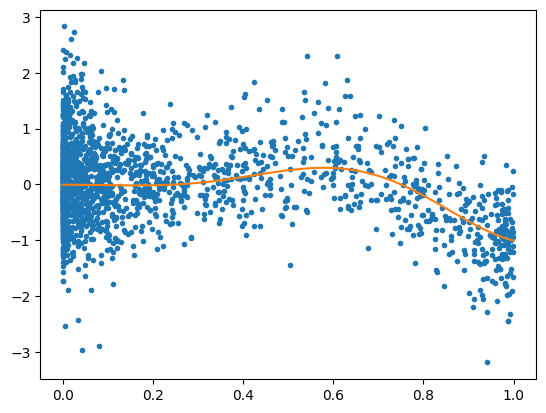

In [6]:
plt.plot(T, Y, '.')
plt.plot(treatment_doses, effects)

In [7]:
## Main prediction loop. Takes about 6 minutes to run.
list_of_ates = [] # [(N_DISC, ates)]

for N_DISC in N_DISC_VALUES:
    print(f"N_DISC: {N_DISC}")
    discrete_treatment_levels = np.linspace(0, 1, N_DISC)
    T_discrete = discretize_treatment(T, N_DISC)
    ates = []
    for i, t in enumerate(discrete_treatment_levels[:-1]):
        t0, t1 = discrete_treatment_levels[i], discrete_treatment_levels[i + 1]
        ids = (np.abs(T_discrete - t0) < 1e-4) | (np.abs(T_discrete - t1) < 1e-4)
        T_temp = np.where(np.abs(T_discrete[ids] - t0) < 1e-4, 0, 1).astype(np.float32)
        X_temp = X[ids].astype(np.float32)
        Y_temp = Y[ids].astype(np.float32)
        causalpfn_ate = ATEEstimator(
            device=device,
            verbose=True
        )
        causalpfn_ate.fit(X_temp, T_temp, Y_temp)
        ate = causalpfn_ate.estimate_ate()
        ates.append(ate)
    list_of_ates.append((N_DISC, ates))

N_DISC: 2


Predicting CEPO: 100%|██████████| 4000/4000 [00:08<00:00, 493.12it/s]


N_DISC: 3


Predicting CEPO: 100%|██████████| 1148/1148 [00:01<00:00, 695.23it/s]


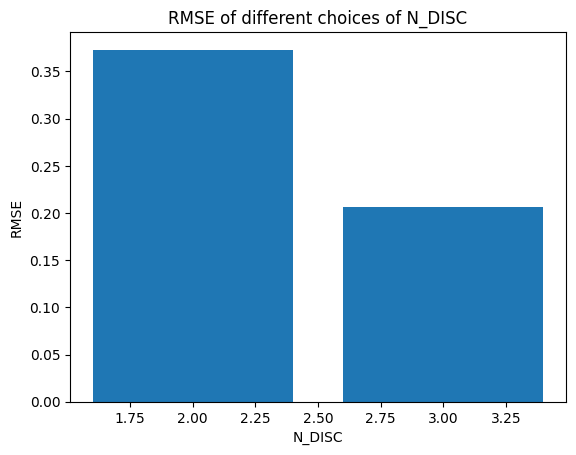

In [15]:

# To get a good RMSE estimate for all the predictions, need a large mesh
fine_mesh = np.linspace(0, 1, 100) # fixed, fine mesh
t_mesh = [np.linspace(0, 1, N_DISC) for N_DISC in N_DISC_VALUES] # to ensure all discrete treatment values are hit
t_mesh += [fine_mesh]
t_mesh = reduce(np.union1d, tuple(t_mesh))
y_true = np.interp(t_mesh, treatment_doses, effects)

# Get RMSE by evaluating on each of the t_mesh points
rmse_dict = dict()
for N_DISC, ates in list_of_ates:
    epos = [sum(ates[:i]) for i in range(N_DISC)]
    y_pred = np.interp(t_mesh, np.linspace(0, 1, N_DISC), epos)
    error = calculate_rmse(y_pred, y_true)
    rmse_dict[N_DISC] = np.round(error, 4)

# Create dataframe, print optimizer, and save the data
df = pd.DataFrame.from_dict(rmse_dict, orient="index", columns=["RMSE"])
row = df[df["RMSE"] == df["RMSE"].min()]
df.to_csv("../output/ADMIT_rmse_table.csv")

fig = plt.figure()
plt.bar(df.index, height=df["RMSE"])
plt.xlabel("N_DISC")
plt.ylabel("RMSE")
plt.title("RMSE of different choices of N_DISC")
plt.savefig("../output/ADMIT_rmse_bar_chart.png")


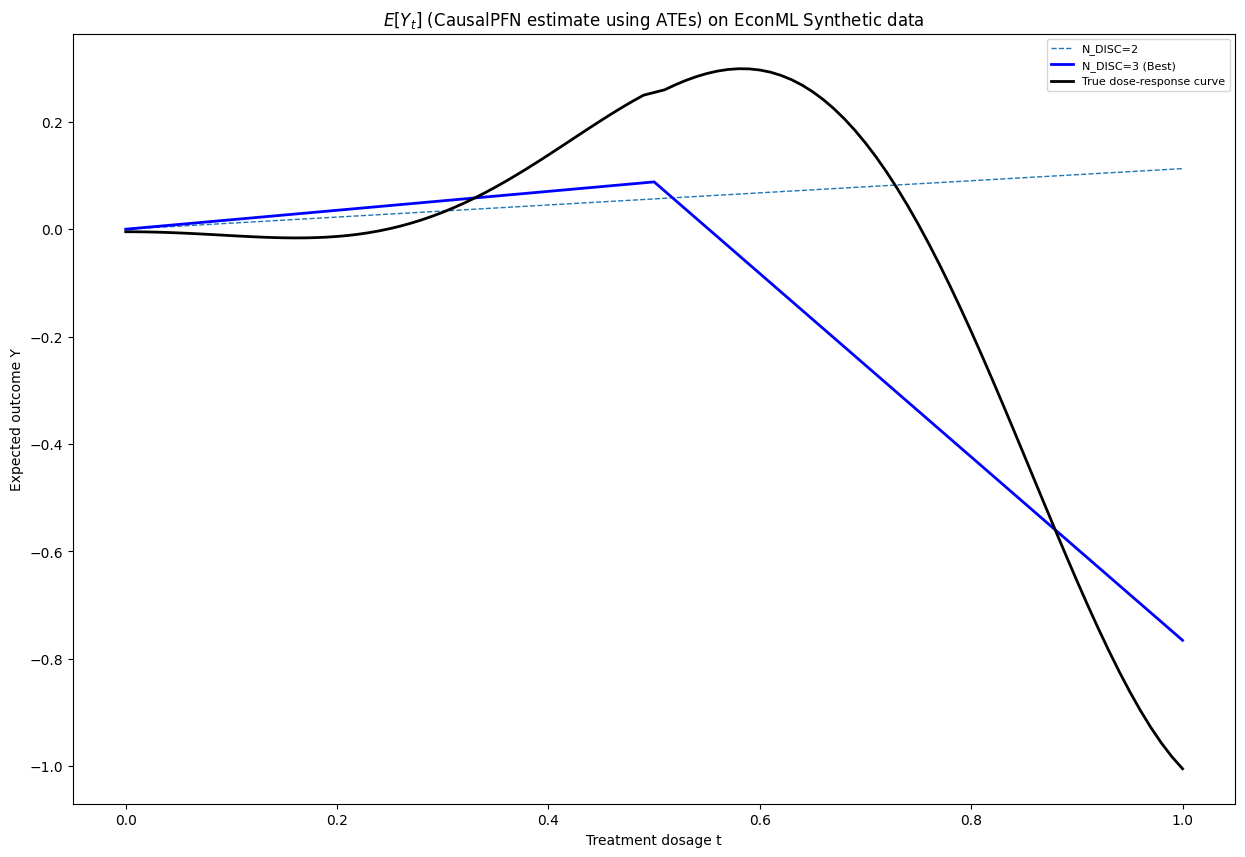

In [16]:
# Plot predictions
fig = plt.figure(figsize=(15, 10))
i = 0 # counter for visual effects
for N_DISC, ates in list_of_ates:
    epos = [sum(ates[:i]) for i in range(N_DISC)]
    if df.loc[N_DISC, "RMSE"] == df.min().values: # Emphasize best prediction
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos, '-', linewidth=2,
                 label=f"N_DISC={N_DISC} (Best)", c="blue", zorder=14)
    else:
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos, '--', linewidth=1,
                 label=f"N_DISC={N_DISC}")
    i += 1

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, len(y_true)), y_true,
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ (CausalPFN estimate using ATEs) on EconML Synthetic data") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")

plt.legend(fontsize=8)
plt.savefig("../output/ADMIT_drf_plot.png", dpi=500)
